## Majority Vote Support Vector Classifier for emotion, based on 4 simple features

Binary classification for each emotion. Trained on 20/80 test/train split of the shuffeled data.
Balances data to account for imbalanced data (some emotions are not reported as often as others)

Now we do not take the mean or median over the features but we perform classification on all data and then do a majority vote.

Training takes approx 1 hour per emotion in google collab. Results are bad (worse than random).


### 3 songs shorter than 60 seconds are not considered!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy

In [2]:
def StrechArrays(Listofarrays):
    """
    Since we possibly use different window and hop sizes for computing the simple features we have arrays of different size. 
    For majority vote classification we need data arrays of same length
    Since they all correspond to the same time axis, we can 'stretch' the array by repeating values
    This function returns 'stretched' arrays with lenght equal to the length of the largest array.
    """
    Nsongs = np.shape(Listofarrays[0])[0]
    maxlength = 0
    for array in Listofarrays:
        if not array.ndim == 1:
            maxlength = max(maxlength, np.shape(array)[1])
    SOL = []
    for array in Listofarrays:
        length = np.shape(array)[1] if not array.ndim == 1 else 1
        if not length == maxlength:
            newarray = np.zeros((Nsongs, maxlength))
            for song in range(Nsongs):
                arr = []
                for i in range(maxlength):
                    arr.append(array[song, int(i*length/maxlength)]
                               ) if not array.ndim == 1 else arr.append(array[song])
                newarray[song, :] = np.array(arr)
            assert np.shape(newarray) == (Nsongs, maxlength)
            SOL.append(newarray)
        else:
            assert np.shape(array) == (Nsongs, maxlength)
            SOL.append(array)
    return SOL, int(maxlength)

In [3]:
# def removeNaN(features, labels):
#     # Look for NaN values in features dataframe and drop these rows and the corresponding rows in label dataframe

#     NaNidx = np.where(features.isnull().any(axis=1).tolist())[0]

#     F = features.drop(NaNidx, axis=0)
#     L = labels.drop(NaNidx, axis=0)
#     features = F.reset_index(drop=True)
#     labels = L.reset_index(drop=True)
#     assert not (F.isnull()).any().any(), 'NaN values in features not removed'
    
#     return F, L

In [4]:
def removeNaN(ZC, SC, SV, ST, labels):
    
    song_idx = [] # rows containing NaN
    
    for array in [ZC, SV, SC, ST]:
        song_idx.extend(np.unique(np.argwhere(np.isnan(array))[:,0] ).tolist() )

    ZC = np.delete(ZC, song_idx, axis=0)
    SC = np.delete(SC, song_idx, axis=0)
    SV = np.delete(SV, song_idx, axis=0)
    ST = np.delete(ST, song_idx, axis=0)
    labels = labels.drop(song_idx, axis=0)
    labels = labels.reset_index(drop=True)

    i=0
    for array in [ZC, SV, SC, ST]:
        assert not (np.isnan(array)).any().any(), f'NaN values in features not removed {i}'
        i+=1
        
    return ZC, SC, SV, ST, labels


In [6]:
def MajorityVote(test_prediction, N_data_per_song):
    number_test_songs = np.shape(test_prediction)[0] / N_data_per_song
    assert number_test_songs == 80  #temporary check

    p = np.reshape(test_prediction, (int(number_test_songs), int(N_data_per_song)))
    
    MV = np.rint(np.mean(p, axis=1)) #take the mean per song and round to the nearest integer to take the majority vote
    
    assert np.shape(MV) == (number_test_songs,)
    return MV

In [5]:
def TrainTestMVreturnCM(features_train, features_test, labels_train, labels_test, N_data_per_song):

    # Standardizing data
    mean = features_train.mean()
    std = features_train.std()

    train_df = (features_train - mean) / std
    test_df = (features_test - mean) / std

    # Classifier
    clf = svm.SVC(kernel='linear', class_weight='balanced')
    clf.fit(train_df, labels_train)
    
    test_prediction = clf.predict(test_df)
    majority_vote = MajorityVote(test_prediction, N_data_per_song)
    CM = confusion_matrix(labels_test, majority_vote, labels= [0,1])

    return CM, clf

In [7]:
# # Data import

# ZC = np.load('../preprocessing/zeroCrossings_frame100ms_hop50ms.npy')
# SC = np.load('../preprocessing/spectralCentroid_frame100ms_hop50ms.npy')
# SV = np.load('../preprocessing/spectralVariance_frame5000ms_hop2500ms.npy')
# ST = np.load('../preprocessing/staticTempoLibrosa.npy')

# labels = pd.read_csv('../preprocessing/labels.csv')

In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

ZC = np.load('gdrive/My Drive/Colab Notebooks/zeroCrossings_frame100ms_hop50ms.npy')
SC = np.load('gdrive/My Drive/Colab Notebooks/spectralCentroid_frame100ms_hop50ms.npy')
SV = np.load('gdrive/My Drive/Colab Notebooks/spectralVariance_frame5000ms_hop2500ms.npy')
ST = np.load('gdrive/My Drive/Colab Notebooks/staticTempoLibrosa.npy')

labels = pd.read_csv('gdrive/My Drive/Colab Notebooks/labels.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Only keep the emotion labels 
# These correspond to the average number each specific emotion was reported

# For classifying we threshold these averages at 0.5. 
# Average > 0.5: this emotion corresponds to this song
# Average < 0.5: emotion does not belong to this song

labels = labels.drop(['genre',
             'var_amazement',
             'var_solemnity',
             'var_tenderness',
             'var_nostalgia',
             'var_calmness',
             'var_power',
             'var_joyful_activation',
             'var_tension',
             'var_sadness',
             'mood',
             'var_mood',
             'liked',
             'var_liked',
             'disliked',
             'var_disliked',
             'age',
             'var_age',
             'gender',
             'var_gender',
             'number_of_observations',
             'track id'             
            ], axis=1)

emotions = list(labels)

In [9]:
np.mean(labels)

amazement            0.134012
solemnity            0.195961
tenderness           0.176911
nostalgia            0.254279
calmness             0.299257
power                0.190244
joyful_activation    0.261896
tension              0.237685
sadness              0.185288
dtype: float64

------------------------------

In [10]:
from sklearn.model_selection import train_test_split

"""
For convenience we remove the 3 songs that are shorter than 60 seconds. 
Actually we should take them into account to avoid unbalancing the data unnecessarily 
"""
ZC, SC, SV, ST, labels = removeNaN(ZC, SC, SV, ST, labels)


ZC_train, ZC_test, SV_train, SV_test, SC_train, SC_test, ST_train, ST_test, labels_train, labels_test = train_test_split(
    ZC, SV, SC, ST, labels, test_size=0.2, shuffle=True)

In [11]:
assert np.shape(ZC) != np.shape(ST)

[ZC_train, SC_train, SV_train, ST_train], Ndata_per_song = StrechArrays(
    [ZC_train, SC_train, SV_train, ST_train])

[ZC_test, SC_test, SV_test, ST_test], Ndata_per_song_test = StrechArrays(
    [ZC_test, SC_test, SV_test, ST_test])

assert np.shape(ZC_train) == np.shape(SC_train) == np.shape(SV_train) == np.shape(ST_train)
assert Ndata_per_song == Ndata_per_song_test

features_dict_train = {'ZC': ZC_train.flatten(),
                       'SC': SC_train.flatten(),
                       'SV': SV_train.flatten(),
                       'StaticTempo': ST_train.flatten()}
features_train = pd.DataFrame(data=features_dict_train)

features_dict_test = {'ZC': ZC_test.flatten(),
                      'SC': SC_test.flatten(),
                      'SV': SV_test.flatten(),
                      'StaticTempo': ST_test.flatten()}
features_test = pd.DataFrame(data=features_dict_test)

labels_train = pd.DataFrame(labels_train.loc[labels_train.index.repeat(
    Ndata_per_song)])  # repeat to meet the number of features

In [19]:
import pickle


emotion = ['nostalgia']
threshold = 0.5

thresholdedLabel_train = copy.deepcopy(labels_train[emotion])
thresholdedLabel_test = copy.deepcopy(labels_test[emotion])
thresholdedLabel_train[thresholdedLabel_train >= threshold] = int(1)
thresholdedLabel_train[thresholdedLabel_train < threshold] = int(0)
thresholdedLabel_test[thresholdedLabel_test >= threshold] = int(1)
thresholdedLabel_test[thresholdedLabel_test < threshold] = int(0)
CM, clf = TrainTestMVreturnCM(features_train, features_test,
                         thresholdedLabel_train, thresholdedLabel_test, Ndata_per_song)

try:
    np.save('gdrive/My Drive/Colab Notebooks/CM_SVMmajorityvote_nostalgia', CM)
except:
    pass
# save classifier
try:
    with open('gdrive/My Drive/Colab Notebooks/CLASSIFIER_SVMmajorityvote_nostalgia', 'wb') as handle:
        pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
except:
    pass

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------

[[26 46]
 [ 4  4]]





TypeError: ignored

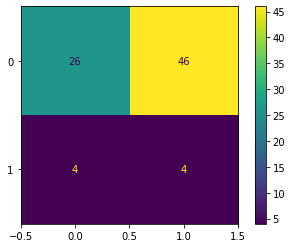

In [21]:
# Confusion matrix

fig,ax = plt.subplots()
CMATRIX = copy.deepcopy(CM)
print(CMATRIX)
print('\n\n')
CM = ConfusionMatrixDisplay(CMATRIX, display_labels=True)
CM.plot(ax=ax)
ax.set_title(f'{emotion}')

In [22]:
30/(30+4+46)

0.375

___

---

In [ ]:
# # Make dataframe

# Ndata_per_song = np.shape(ZC)[1]
# assert Ndata_per_song != 400
# [ZC, SC, SV, ST] = StrechArrays([ZC, SC, SV, ST])
# assert np.shape(ZC) == np.shape(SC) == np.shape(SV) == np.shape(ST)

# features_dict = {'ZC': ZC.flatten(),
#                          'SC': SC.flatten(),
#                          'SV': SV.flatten(),
#                          'StaticTempo': ST.flatten()}
# features = pd.DataFrame(data=features_dict)


# # Remove NaN values
# labels = pd.DataFrame(labels.loc[labels.index.repeat(Ndata_per_song)])  # repeat to meet the number of features
# labels = labels.reset_index(drop=True)
# features, labels = removeNaN(features, labels)
# assert not features.isnull().any().any(), 'features contains NaN'

In [ ]:
# # Doing the actual training of the support vector classifier over multple rounds of shuffeling
# assert not features.isnull().any().any(), 'features contains NaN1'

# threshold = 0.5

# N_emotions = 9
# N_features = 4

# confusion_Matrix = np.zeros((N_emotions, 2, 2))

# N_shuffles = 1
# k = 2
# accuracies = np.zeros((N_emotions, N_shuffles))

# emotions = ['amazement']

# assert not features.isnull().any().any(), 'features contains NaN2'

# for e_idx, emotion in enumerate(emotions):
#     assert not features.isnull().any().any(), 'features contains NaN3'
    
#     for Siter in range(N_shuffles):
#         assert not features.isnull().any().any(), 'features contains NaN4'
        
#         thresholdedLabel = copy.deepcopy(labels[emotion])

#         thresholdedLabel[thresholdedLabel >= threshold] = int(1)
#         thresholdedLabel[thresholdedLabel < threshold] = int(0)
       
#         assert not features.isnull().any().any(), 'features contains NaN5'
        
#         features, thresholdedLabel = shuffleData(features, thresholdedLabel)
#         assert not features.isnull().any().any(), 'features contains NaN6'
#         confusion_Matrix[e_idx, :, :] += kFoldConfusionMatrix(k, features, thresholdedLabel)

#         accuracies[e_idx, Siter] = np.sum(
#             np.eye(2)*confusion_Matrix[e_idx, :, :])/np.sum(confusion_Matrix[e_idx, :, :])

In [ ]:
# # Confusion matrix
# for e_idx, emotion in enumerate(emotions):
#     print(f'EMOTION {emotion}: \n')
#     print(f'Accuracy: {np.mean(accuracies[e_idx, :])} +- {np.std(accuracies[e_idx, :])} \n')

#     fig,ax = plt.subplots()
#     CMATRIX = confusion_Matrix[e_idx, :, :]
#     print(CMATRIX)
#     print('\n\n')
#     CM = ConfusionMatrixDisplay(CMATRIX)
#     CM.plot(ax=ax)
#     ax.set_title(f'{emotion}')

In [5]:
# # Shuffle

# def shuffleData(features, labels):
#     features = features.reset_index(drop=True)
#     labels = labels.reset_index(drop=True)
#     assert not features.isnull().any().any(), 'features contains NaN1'
#     n_data = len(features)
#     idx = np.random.permutation(n_data)
#     features, labels = features.reindex(idx), labels.reindex(idx)
#     assert not features.isnull().any().any(), 'features contains NaN2'
#     return features, labels

In [6]:
# # K fold Crossvalidation

# def kFoldConfusionMatrix(k, features, labels):

# #     kfold_train_metrics = []
# #     kfold_test_metrics = []

#     confusion_Matrix_total = np.zeros((2, 2), dtype= 'int')

#     total_input = features
#     total_labels = labels

#     cv = KFold(n_splits=k)

#     for train_index, test_index in cv.split(total_input):        
#         train_df, train_labels = total_input.iloc[train_index], total_labels.iloc[train_index]
#         test_df, test_labels = total_input.iloc[test_index], total_labels.iloc[test_index]

#         # Standardizing data
#         mean = train_df.mean()
#         std = train_df.std()

#         train_df = (train_df - mean) / std
#         test_df = (test_df - mean) / std

#         # Classifier
#         clf = svm.SVC(kernel='linear', class_weight='balanced')
#         clf.fit(train_df, train_labels)

# #         kfold_train_metrics.append(clf.score(train_df, train_labels))
# #         kfold_test_metrics.append(clf.score(test_df, test_labels))

#         test_prediction = clf.predict(test_df)
    
#         majority_vote = MajorityVote(test_predictoin, N_data_per_song)
    
#         CM = confusion_matrix(test_labels, test_prediction, labels= [0,1])
        

#         confusion_Matrix_total += CM
#     return confusion_Matrix_total